In [1]:
import pandas as pd
import numpy as np
from pandas.io import sql
from sqlalchemy import create_engine
import csv
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
db_user = 'postgres'
db_password = ''
db_host = 'localhost'
db_port = 5432
database = 'climbing'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
connection = create_engine(conn_str)

In [ ]:
df_crags = pd.read_sql('select * from crags',connection,index_col='index')
df_crags['climb_list'] = [eval(flat) for flat in df_crags['climbs_flat']]
df_crags = df_crags.drop('climbs_flat',axis=1)
df_crags

In [ ]:
df_crags.describe()

In [ ]:
df_crags.rocktype.value_counts()

In [3]:
df_climbs = pd.read_sql('select * from climbs',connection,index_col='index')
df_climbs['logs'] = [eval(flat) for flat in df_climbs['logs_flat']]
df_climbs = df_climbs.drop('logs_flat',axis=1)
df_climbs

,url,climbname,rating,grade,crag_id,num_comments,type,num_worded_comments,comments_flat,logs
index,,,,,,,,,,
3166,https://www.ukclimbing.com/logbook/c.php?i=3166,Millwood's Wall,0,S 4a,4,0,trad,0,'',{}
3167,https://www.ukclimbing.com/logbook/c.php?i=3167,Vanishing Point,0,E1 5b,4,2,trad,0,' ',"{'187067': '', '63530': ''}"
3168,https://www.ukclimbing.com/logbook/c.php?i=3168,The Thing,3,E2 5c,4,124,trad,24,""" Joe led this in one pitch, taking the direct...","{'253245': '', '206609': 'Joe led this in one ..."
3169,https://www.ukclimbing.com/logbook/c.php?i=3169,Rootorooni,1,E3 5c,4,0,trad,0,'',{}
3170,https://www.ukclimbing.com/logbook/c.php?i=3170,Cobweb Crack,2,VS 5a,4,181,trad,41,' Note that the description in the CC Llanbe...,"{'185136': '', '197782': '', '6106': '', '2410..."
...,...,...,...,...,...,...,...,...,...,...
560510,https://www.ukclimbing.com/logbook/c.php?i=560510,El chivo loco,0,6b,27432,0,lead,0,'',{}
560511,https://www.ukclimbing.com/logbook/c.php?i=560511,Victorking,0,6b+,27432,0,lead,0,'',{}
560512,https://www.ukclimbing.com/logbook/c.php?i=560512,Puto Maldonado,0,6c+,27432,0,lead,0,'',{}


In [4]:
df_climbs.type.value_counts()

lead       209346
boulder    110784
trad       102743
other       70109
Name: type, dtype: int64

In [5]:
df_climbs.num_comments.sum()

5208323

In [6]:
df_climbs.num_worded_comments.sum()

873917

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
df_test = df_climbs[(df_climbs['num_worded_comments']>10) & (df_climbs['type']=='boulder')]

In [17]:
cv_climbing_words = TfidfVectorizer(ngram_range=(1,2),stop_words='english')

climbs_nlp_spmat = cv_climbing_words.fit_transform(df_test.comments_flat.values)
climbs_nlp_spmat

<1618x128853 sparse matrix of type '<class 'numpy.float64'>'
	with 349751 stored elements in Compressed Sparse Row format>

In [18]:
climbs_nlp = pd.DataFrame(climbs_nlp_spmat.asformat('array'),columns=cv_climbing_words.get_feature_names(),index=df_test.index)


In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


In [20]:
def num_there(s):
    return any(i.isdigit() for i in s)

In [21]:
def get_vocab(columns):
    vocab = []
    for i in tqdm(columns):
        sent = analyser.polarity_scores(i)
        if len(i.split())==1 and sent['neu'] == 1 and num_there(i)==False:
            vocab.append(i.lower())
        elif len(i.split())>1 and num_there(i)==False:
            vocab.append(i.lower())
    return vocab

In [22]:
vocab = get_vocab(climbs_nlp.columns)

In [23]:
len(vocab)

115827

In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [25]:
pca = TruncatedSVD(n_components=10)
data_fit = pca.fit_transform(climbs_nlp[vocab])

In [26]:
model = KMeans(n_clusters = 10)

model.fit(data_fit)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
df_test['labels'] = model.labels_

/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_test.labels.value_counts()

8    482
4    372
9    156
5    146
3    141
0    128
7     83
1     51
6     42
2     17
Name: labels, dtype: int64

In [29]:
from wordcloud import WordCloud

In [30]:

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    return wordcloud

In [31]:
def col_to_flat(comments_flat):
    total_flat = ""
    for comments in tqdm(comments_flat):
        for word in comments.split():
            if word.lower() in vocab:
                total_flat = total_flat + " " + word 
    return total_flat

0



1



2



3



4



5



6



7



8


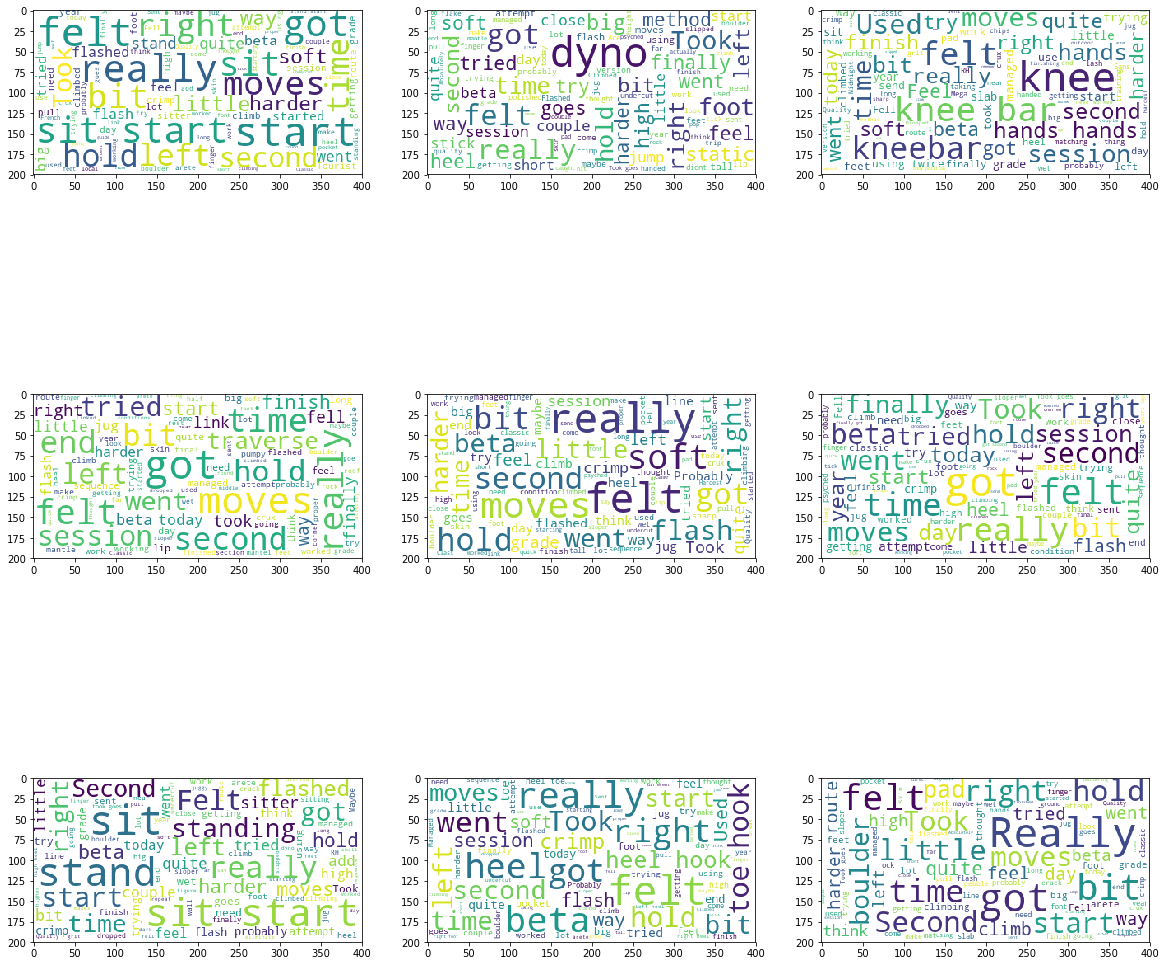

In [32]:
rows=3
cols=3
fig,ax = plt.subplots(figsize=(20,20), ncols=cols,nrows=rows)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        print(count)
        plot_words = col_to_flat(df_test[df_test['labels']==count].comments_flat)
        ax[i][j].imshow(plot_word_cloud(plot_words))
        count +=1
plt.show()

In [178]:
df_users = pd.read_sql('select * from users',connection,index_col='index')
df_users['climbs'] = [eval(flat) for flat in df_users['climbs_flat']]
df_users = df_users.drop('climbs_flat',axis=1)
df_users

,logbook_url,profile_url,username,num_climbs,climbs
index,,,,,
100002,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,Stephanelericolais,3,"[42012, 18853, 147314]"
10002,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,Piers Harley,323,"[10911, 2367, 8359, 10744, 10726, 10731, 10732..."
100025,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,george5699,15,"[31435, 33329, 40976, 86139, 42231, 35261, 352..."
100031,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,Tak,16,"[10917, 10941, 10969, 10971, 10399, 10328, 103..."
100045,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,smeaton,46,"[10729, 10731, 10735, 10816, 10838, 10814, 108..."
...,...,...,...,...,...
99962,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,spilla,19,"[10370, 14064, 14065, 14066, 14060, 14061, 514..."
99967,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,Andrewbirkett,68,"[33152, 33154, 33286, 35960, 37260, 33289, 104..."
99978,https://www.ukclimbing.com/logbook/showlog.php...,https://www.ukclimbing.com/user/profile.php?id...,Jamie Nobbs,74,"[8354, 8349, 8351, 4662, 34668, 4684, 4694, 47..."


In [179]:
df_users.num_climbs.mean()

145.40718447226962

In [180]:
from sklearn.preprocessing import MultiLabelBinarizer


# Binarise labels
mlb = MultiLabelBinarizer(sparse_output=True)
expandedLabelData = mlb.fit_transform(df_users.climbs)
labelClasses = mlb.classes_


# Create a pandas.DataFrame from our output


In [181]:
expandedLabelData

<31067x270544 sparse matrix of type '<class 'numpy.int64'>'
	with 4517365 stored elements in Compressed Sparse Row format>